# Hazard Rates & Bond Basis Analysis
## Understanding Credit Risk Parallel to Interest Rate Risk

This notebook explores:
1. **Hazard Rates (Credit Spreads)**: How credit risk is modeled and simulated in parallel with interest rates
2. **Bond Basis for Callable Bonds**: Cash vs Forward pricing and basis decomposition
3. **Joint Dynamics**: How interest rate and credit risk interact
4. **Risk Sensitivities**: How IR01, CR01, and Vega respond to basis changes

**Key Concepts**:
- **Hazard Rate**: Instantaneous probability of default per unit time
- **Bond Basis**: Difference between cash price and implied forward price
- **Carry**: Profits from holding bond over forward period
- **Roll-Down**: Price appreciation from curve flattening

In [1]:
# Import Required Libraries
import sys
sys.path.append('/Users/guangchuyan/Desktop/Projects/Callable_Bond/src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Import modules
from callable_bond import (
    CallableBond, CallableBondParameters, VasicekParams, HazardRateParams,
    RateModelType, CallableType, VasicekModel, HazardRateModel, 
    StraightBondPricer, CallableOptionPricer
)
from yield_curve import YieldCurve, Instrument
from bond_basis import Bond, BondBasisAnalysis, analyze_bond_basis

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully")
print("✓ Callable bond, yield curve, and bond basis modules loaded")

✓ All libraries imported successfully
✓ Callable bond, yield curve, and bond basis modules loaded


## Section 1: Understanding Hazard Rates - The Math

### What is a Hazard Rate?

The **hazard rate** (or intensity rate) h(t) represents the **instantaneous probability of default** at time t, conditional on survival up to that time.

$$P(\text{survival until time } T) = e^{-\int_0^T h(t) dt}$$

### The Hazard Rate SDE

We model hazard rates similar to interest rates using a mean-reverting SDE:

$$dh_t = \kappa_h(\lambda_0 - h_t)dt + \sigma_h dW_t^h$$

Where:
- **h_t**: Hazard rate at time t
- **κ_h**: Mean reversion speed (how quickly spreads revert to normal)
- **λ_0**: Long-term mean hazard rate
- **σ_h**: Volatility of hazard rates
- **dW_t^h**: Brownian motion (correlated with interest rates)

### Key Relationships

**Credit Spread** ≈ Hazard Rate × (1 - Recovery Rate)

Example: If hazard rate = 2% and recovery = 40%, then credit spread ≈ 1.2%

**Survival Probability** = Probability of receiving full cash flows (no default)

**Bond Price with Credit Risk** = Bond Price (assuming no default) × Survival Probability

In [2]:
# Define Models and Parameters
print("=" * 70)
print("SETTING UP HAZARD RATE AND INTEREST RATE MODELS")
print("=" * 70 + "\n")

# Interest Rate Model Parameters
ir_params = VasicekParams(
    mean_reversion=0.15,
    long_term_mean=0.05,
    volatility=0.015,
    initial_rate=0.04
)

# Hazard Rate Model Parameters
hazard_params = HazardRateParams(
    mean_reversion=0.10,          # Spreads mean-revert slower than rates
    long_term_mean=0.025,         # Long-term hazard rate (2.5%)
    volatility=0.012,             # Spread volatility slightly lower than rates
    initial_hazard=0.020,         # Current hazard rate (2%)
    recovery_rate=0.40
)

print("INTEREST RATE MODEL (Vasicek)")
print("-" * 70)
print(f"Initial Rate (r0):        {ir_params.initial_rate*100:.3f}%")
print(f"Long-term Mean (θ):       {ir_params.long_term_mean*100:.3f}%")
print(f"Mean Reversion (κ):       {ir_params.mean_reversion:.4f}")
print(f"Volatility (σ):           {ir_params.volatility*100:.3f}%")

print("\nHAZARD RATE MODEL (Vasicek-style)")
print("-" * 70)
print(f"Initial Hazard (h0):      {hazard_params.initial_hazard*100:.3f}%")
print(f"Long-term Mean (λ0):      {hazard_params.long_term_mean*100:.3f}%")
print(f"Mean Reversion (κ_h):     {hazard_params.mean_reversion:.4f}")
print(f"Volatility (σ_h):         {hazard_params.volatility*100:.3f}%")
print(f"Recovery Rate:            {hazard_params.recovery_rate*100:.1f}%")

# Implied credit spread (approximation)
implied_spread = hazard_params.initial_hazard * (1 - hazard_params.recovery_rate)
print(f"\nImplied Credit Spread:    {implied_spread*100:.3f}%")

# Simulate parallel paths
num_paths = 2000
t_steps = 252
maturity = 5.0

print("\n" + "=" * 70)
print("SIMULATING PARALLEL INTEREST RATE AND HAZARD RATE PATHS")
print("=" * 70)
print(f"Number of paths:          {num_paths}")
print(f"Time steps:               {t_steps}")
print(f"Time horizon:             {maturity} years\n")

# Create and simulate models
vasicek_model = VasicekModel(ir_params)
hazard_model = HazardRateModel(hazard_params)

rate_paths = vasicek_model.simulate_path(int(t_steps * maturity), num_paths, seed=42)
hazard_paths = hazard_model.simulate_path(int(t_steps * maturity), num_paths, seed=42)

time_grid = np.linspace(0, maturity, rate_paths.shape[0])

# Calculate statistics
ir_mean = np.mean(rate_paths, axis=1)
ir_std = np.std(rate_paths, axis=1)
ir_p5 = np.percentile(rate_paths, 5, axis=1)
ir_p95 = np.percentile(rate_paths, 95, axis=1)

hazard_mean = np.mean(hazard_paths, axis=1)
hazard_std = np.std(hazard_paths, axis=1)
hazard_p5 = np.percentile(hazard_paths, 5, axis=1)
hazard_p95 = np.percentile(hazard_paths, 95, axis=1)

print("✓ Paths simulated successfully\n")

print("INTEREST RATE STATISTICS AT MATURITY (t=5Y)")
print("-" * 70)
print(f"Mean:                     {np.mean(rate_paths[-1, :])*100:.3f}%")
print(f"Std Dev:                  {np.std(rate_paths[-1, :])*100:.3f}%")
print(f"5th Percentile:           {np.percentile(rate_paths[-1, :], 5)*100:.3f}%")
print(f"95th Percentile:          {np.percentile(rate_paths[-1, :], 95)*100:.3f}%")

print("\nHAZARD RATE STATISTICS AT MATURITY (t=5Y)")
print("-" * 70)
print(f"Mean:                     {np.mean(hazard_paths[-1, :])*100:.3f}%")
print(f"Std Dev:                  {np.std(hazard_paths[-1, :])*100:.3f}%")
print(f"5th Percentile:           {np.percentile(hazard_paths[-1, :], 5)*100:.3f}%")
print(f"95th Percentile:          {np.percentile(hazard_paths[-1, :], 95)*100:.3f}%")

SETTING UP HAZARD RATE AND INTEREST RATE MODELS

INTEREST RATE MODEL (Vasicek)
----------------------------------------------------------------------
Initial Rate (r0):        4.000%
Long-term Mean (θ):       5.000%
Mean Reversion (κ):       0.1500
Volatility (σ):           1.500%

HAZARD RATE MODEL (Vasicek-style)
----------------------------------------------------------------------
Initial Hazard (h0):      2.000%
Long-term Mean (λ0):      2.500%
Mean Reversion (κ_h):     0.1000
Volatility (σ_h):         1.200%
Recovery Rate:            40.0%

Implied Credit Spread:    1.200%

SIMULATING PARALLEL INTEREST RATE AND HAZARD RATE PATHS
Number of paths:          2000
Time steps:               252
Time horizon:             5.0 years

✓ Paths simulated successfully

INTEREST RATE STATISTICS AT MATURITY (t=5Y)
----------------------------------------------------------------------
Mean:                     4.120%
Std Dev:                  1.405%
5th Percentile:           1.804%
95th Percenti

## Section 2: Visualize Parallel Paths - Interest Rates vs Hazard Rates

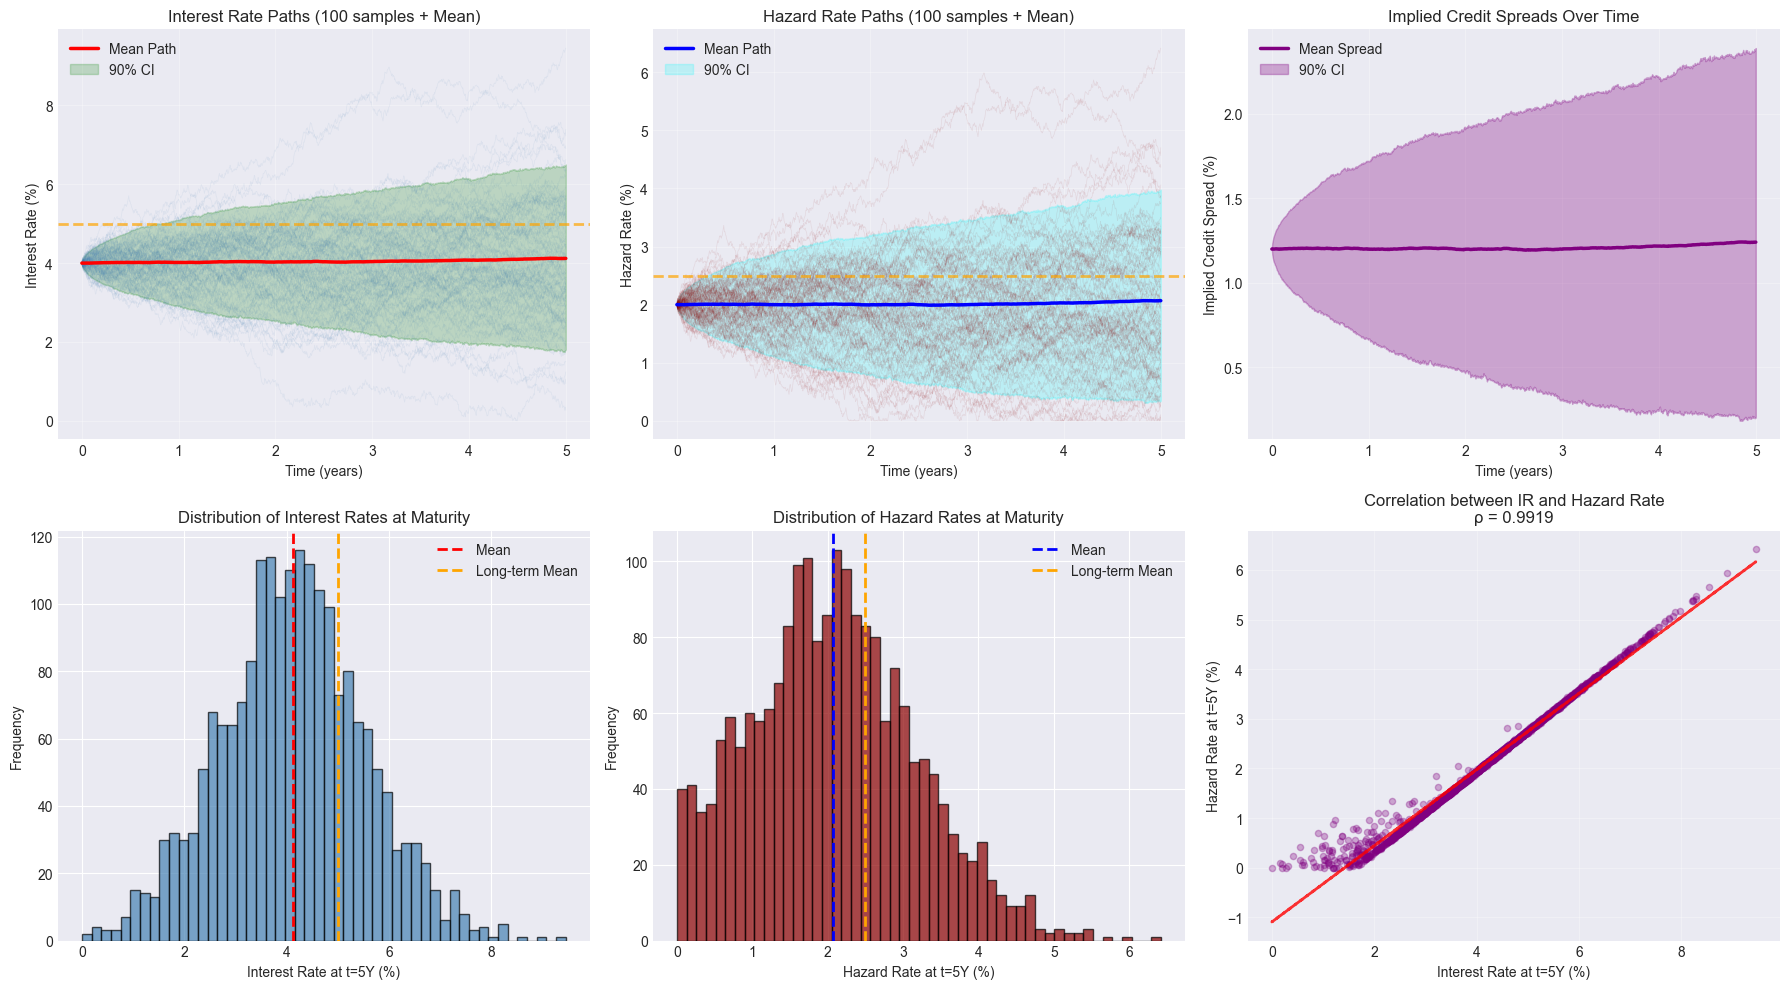


Correlation between Interest Rates and Hazard Rates: 0.9919


In [3]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Sample IR paths
ax1 = axes[0, 0]
sample_indices = np.random.choice(num_paths, 100, replace=False)
for i in sample_indices:
    ax1.plot(time_grid, rate_paths[:, i] * 100, alpha=0.08, color='steelblue', linewidth=0.5)
ax1.plot(time_grid, ir_mean * 100, color='red', linewidth=2.5, label='Mean Path')
ax1.fill_between(time_grid, ir_p5 * 100, ir_p95 * 100, alpha=0.2, color='green', label='90% CI')
ax1.axhline(y=ir_params.long_term_mean * 100, color='orange', linestyle='--', alpha=0.7, linewidth=2)
ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Interest Rate (%)')
ax1.set_title('Interest Rate Paths (100 samples + Mean)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Sample Hazard Rate paths
ax2 = axes[0, 1]
for i in sample_indices:
    ax2.plot(time_grid, hazard_paths[:, i] * 100, alpha=0.08, color='darkred', linewidth=0.5)
ax2.plot(time_grid, hazard_mean * 100, color='blue', linewidth=2.5, label='Mean Path')
ax2.fill_between(time_grid, hazard_p5 * 100, hazard_p95 * 100, alpha=0.2, color='cyan', label='90% CI')
ax2.axhline(y=hazard_params.long_term_mean * 100, color='orange', linestyle='--', alpha=0.7, linewidth=2)
ax2.set_xlabel('Time (years)')
ax2.set_ylabel('Hazard Rate (%)')
ax2.set_title('Hazard Rate Paths (100 samples + Mean)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Implied Credit Spreads over time
ax3 = axes[0, 2]
implied_spreads = hazard_paths * (1 - hazard_params.recovery_rate)
spread_mean = np.mean(implied_spreads, axis=1)
spread_p5 = np.percentile(implied_spreads, 5, axis=1)
spread_p95 = np.percentile(implied_spreads, 95, axis=1)
ax3.plot(time_grid, spread_mean * 100, color='purple', linewidth=2.5, label='Mean Spread')
ax3.fill_between(time_grid, spread_p5 * 100, spread_p95 * 100, alpha=0.3, color='purple', label='90% CI')
ax3.set_xlabel('Time (years)')
ax3.set_ylabel('Implied Credit Spread (%)')
ax3.set_title('Implied Credit Spreads Over Time')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Distribution of IR at maturity
ax4 = axes[1, 0]
ax4.hist(rate_paths[-1, :] * 100, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax4.axvline(ir_mean[-1] * 100, color='red', linestyle='--', linewidth=2, label='Mean')
ax4.axvline(ir_params.long_term_mean * 100, color='orange', linestyle='--', linewidth=2, label='Long-term Mean')
ax4.set_xlabel('Interest Rate at t=5Y (%)')
ax4.set_ylabel('Frequency')
ax4.set_title(f'Distribution of Interest Rates at Maturity')
ax4.legend()

# Plot 5: Distribution of Hazard Rate at maturity
ax5 = axes[1, 1]
ax5.hist(hazard_paths[-1, :] * 100, bins=50, alpha=0.7, color='darkred', edgecolor='black')
ax5.axvline(hazard_mean[-1] * 100, color='blue', linestyle='--', linewidth=2, label='Mean')
ax5.axvline(hazard_params.long_term_mean * 100, color='orange', linestyle='--', linewidth=2, label='Long-term Mean')
ax5.set_xlabel('Hazard Rate at t=5Y (%)')
ax5.set_ylabel('Frequency')
ax5.set_title(f'Distribution of Hazard Rates at Maturity')
ax5.legend()

# Plot 6: Correlation between IR and Hazard Rate
ax6 = axes[1, 2]
ir_flat = rate_paths[-1, :]
hazard_flat = hazard_paths[-1, :]
correlation = np.corrcoef(ir_flat, hazard_flat)[0, 1]
ax6.scatter(ir_flat * 100, hazard_flat * 100, alpha=0.3, s=20, color='purple')
ax6.set_xlabel('Interest Rate at t=5Y (%)')
ax6.set_ylabel('Hazard Rate at t=5Y (%)')
ax6.set_title(f'Correlation between IR and Hazard Rate\nρ = {correlation:.4f}')
ax6.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(ir_flat, hazard_flat, 1)
p = np.poly1d(z)
ax6.plot(ir_flat * 100, p(ir_flat) * 100, "r--", linewidth=2, alpha=0.8)

plt.tight_layout()
plt.show()

print(f"\nCorrelation between Interest Rates and Hazard Rates: {correlation:.4f}")

## Section 3: Understanding Bond Basis

### What is Bond Basis?

The **bond basis** (or "cash-and-carry basis") measures the value of owning a bond in cash versus transacting synthetically through the forward market:

$$\text{Basis} = \text{Cash Price} - \text{Implied Forward Price}$$

### Forward Price Calculation

There are two equivalent methods:

**Method 1: Using Forward Rates**
$$P_{\text{forward}} = \sum_{t} \frac{\text{CF}_t}{\text{DF}(t_0 \to t)}$$

Where DF(t₀ → t) is the forward discount factor from settlement date t₀ to cash flow date t.

**Method 2: Using Financing Costs**
$$P_{\text{forward}} = P_{\text{spot}} \cdot e^{r \cdot T} - \text{Coupons Received (reinvested)}$$

Where r is the repo rate.

### Basis Components (Carry Decomposition)

$$\text{Basis} \approx \text{Coupon Accrual} - \text{Financing Cost} + \text{Roll-Down}$$

**Coupon Accrual**: Interest earned from holding bond
**Financing Cost**: Cost to borrow money to buy bond  
**Roll-Down**: Price appreciation from curve flattening (if steep curve)

### Basis Trading Strategy

- **Positive Basis**: Bond is cheap vs forward → BUY cash, SHORT forward
- **Negative Basis**: Bond is expensive vs forward → SELL cash, BUY forward

In [4]:
## Section 4: Calculate Bond Basis for Callable Bonds

# First, build a yield curve from spot rates
print("\n" + "=" * 70)
print("BUILDING YIELD CURVE")
print("=" * 70)

# Create synthetic instruments based on Vasicek model mean rates
# We'll use the expected spot rates from our simulation
synthetic_instruments = [
    Instrument(maturity=0.5, coupon_rate=0.00, price=98.0, coupon_frequency=2),
    Instrument(maturity=1.0, coupon_rate=0.04, price=99.5, coupon_frequency=2),
    Instrument(maturity=2.0, coupon_rate=0.045, price=99.8, coupon_frequency=2),
    Instrument(maturity=3.0, coupon_rate=0.05, price=100.0, coupon_frequency=2),
    Instrument(maturity=5.0, coupon_rate=0.055, price=100.2, coupon_frequency=2),
    Instrument(maturity=7.0, coupon_rate=0.06, price=100.5, coupon_frequency=2),
]

# Build curve
yield_curve = YieldCurve()
yield_curve.bootstrap(synthetic_instruments)

print("Yield Curve constructed from 6 instruments")
print("\nSpot Rates at Key Maturities:")
for mat in [1, 2, 3, 5, 7]:
    zr = yield_curve.get_spot_rate(mat)
    print(f"  {mat}-year: {zr*100:.3f}%")

# Now create a callable bond
print("\n" + "=" * 70)
print("CREATING CALLABLE BOND FOR BASIS ANALYSIS")
print("=" * 70 + "\n")

bond_params = CallableBondParameters(
    par_value=100.0,
    coupon_rate=0.055,
    maturity=5.0,
    coupon_frequency=2,
    call_price=102.0,
    first_call_date=2.0,
    callable_type=CallableType.AMERICAN
)

print(f"Bond Parameters:")
print(f"  Par Value:        ${bond_params.par_value:.2f}")
print(f"  Coupon:           {bond_params.coupon_rate*100:.2f}%")
print(f"  Maturity:         {bond_params.maturity:.1f} years")
print(f"  Call Price:       ${bond_params.call_price:.2f}")
print(f"  First Call Date:  {bond_params.first_call_date:.1f} years")

# Create Bond object for basis calculation
callable_bond_obj = Bond(
    name="5Y Callable Bond",
    maturity=bond_params.maturity,
    coupon_rate=bond_params.coupon_rate,
    price=99.5,  # Current market price
    par_value=bond_params.par_value,
    coupon_frequency=bond_params.coupon_frequency
)

print(f"\n{callable_bond_obj}")

# Calculate basis for different forward dates
forward_dates = [0.5, 1.0, 1.5, 2.0, 3.0]
repo_rate = 0.03  # 3% repo financing rate

print("\n" + "=" * 70)
print("BOND BASIS ANALYSIS")
print("=" * 70)

basis_results = []

for fwd_date in forward_dates:
    basis_analysis = analyze_bond_basis(
        bond=callable_bond_obj,
        yield_curve=yield_curve,
        forward_date=fwd_date,
        repo_rate=repo_rate
    )
    
    basis = basis_analysis.calculate_basis()
    basis_bps = basis_analysis.calculate_basis_bps()
    carry = basis_analysis.calculate_carry()
    forward_price = basis_analysis.calculate_forward_price()
    
    basis_results.append({
        'Forward Date': fwd_date,
        'Forward Price': forward_price,
        'Basis (%)': basis,
        'Basis (bps)': basis_bps,
        'Coupon Accrual': carry['coupon_accrual'],
        'Financing Cost': carry['financing_cost'],
        'Roll-Down': carry['roll_down'],
        'Total Carry': carry['total_carry']
    })
    
    print(f"\nForward Date: {fwd_date:.1f}Y")
    print(f"  Forward Price:     {forward_price:>10.4f}")
    print(f"  Cash Price:        {callable_bond_obj.price:>10.4f}")
    print(f"  Basis:             {basis:>10.4f}  ({basis_bps:>8.2f} bps)")
    print(f"  Carry Breakdown:")
    print(f"    Coupon Accrual:  {carry['coupon_accrual']:>10.4f}")
    print(f"    Financing Cost:  {carry['financing_cost']:>10.4f}")
    print(f"    Roll-Down:       {carry['roll_down']:>10.4f}")
    print(f"    Total Carry:     {carry['total_carry']:>10.4f}")

# Create results dataframe
basis_df = pd.DataFrame(basis_results)
print("\n" + "=" * 70)
print("BASIS SUMMARY TABLE")
print("=" * 70)
display(basis_df)


BUILDING YIELD CURVE
Yield Curve constructed from 6 instruments

Spot Rates at Key Maturities:
  1-year: 4.572%
  2-year: 4.664%
  3-year: 5.091%
  5-year: 5.607%
  7-year: 6.179%

CREATING CALLABLE BOND FOR BASIS ANALYSIS

Bond Parameters:
  Par Value:        $100.00
  Coupon:           5.50%
  Maturity:         5.0 years
  Call Price:       $102.00
  First Call Date:  2.0 years

Bond(name=5Y Callable Bond, maturity=5.0Y, coupon=5.50%, price=99.50)

BOND BASIS ANALYSIS

Forward Date: 0.5Y
  Forward Price:        99.4218
  Cash Price:           99.5000
  Basis:                 0.0782  (    7.82 bps)
  Carry Breakdown:
    Coupon Accrual:      2.7500
    Financing Cost:      1.4925
    Roll-Down:           0.0056
    Total Carry:         1.2631

Forward Date: 1.0Y
  Forward Price:        99.1385
  Cash Price:           99.5000
  Basis:                 0.3615  (   36.15 bps)
  Carry Breakdown:
    Coupon Accrual:      2.7500
    Financing Cost:      2.9850
    Roll-Down:           0.011

,Forward Date,Forward Price,Basis (%),Basis (bps),Coupon Accrual,Financing Cost,Roll-Down,Total Carry
0,0.5,99.421850,0.078150,7.815016,2.75,1.4925,0.005574,1.263074
1,1.0,99.138539,0.361461,36.146083,2.75,2.9850,0.011197,-0.223803
2,1.5,98.647322,0.852678,85.267804,2.75,4.4775,0.017529,-1.709971
3,2.0,98.287489,1.212511,121.251123,2.75,5.9700,0.025663,-3.194337
4,3.0,98.550880,0.949120,94.911977,2.75,8.9550,0.046880,-6.158120


In [ ]:
# Visualize Basis Decomposition
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Basis over forward dates
ax1 = axes[0]
ax1.plot(basis_df['Forward Date'], basis_df['Basis (%)'], 'o-', linewidth=2.5, 
         markersize=8, color='purple', label='Basis')
ax1.fill_between(basis_df['Forward Date'], 0, basis_df['Basis (%)'], alpha=0.3, color='purple')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax1.set_xlabel('Forward Date (years)')
ax1.set_ylabel('Basis (% of par)')
ax1.set_title('Bond Basis Across Forward Dates')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Carry decomposition stacked bar chart
ax2 = axes[1]
x = basis_df['Forward Date']
width = 0.3
coupon = basis_df['Coupon Accrual']
financing = -basis_df['Financing Cost']
rolldown = basis_df['Roll-Down']

ax2.bar(x, coupon, width, label='Coupon Accrual', alpha=0.8, color='green')
ax2.bar(x, financing, width, bottom=coupon, label='Financing Cost Saved', alpha=0.8, color='orange')
ax2.bar(x, rolldown, width, bottom=coupon + financing, label='Roll-Down', alpha=0.8, color='blue')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Forward Date (years)')
ax2.set_ylabel('Carry Component (% of par)')
ax2.set_title('Carry Decomposition (Stacked)')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Total carry comparison
ax3 = axes[2]
colors = ['green' if x > 0 else 'red' for x in basis_df['Total Carry']]
bars = ax3.bar(basis_df['Forward Date'], basis_df['Total Carry'], color=colors, alpha=0.7, 
               edgecolor='black', linewidth=1.5)
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.set_xlabel('Forward Date (years)')
ax3.set_ylabel('Total Carry (% of par)')
ax3.set_title('Total Carry by Forward Date')
ax3.grid(True, alpha=0.3, axis='y')

# Add values on bars
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()

## Section 5: How Basis Reacts to Interest Rate and Credit Spread Changes

### Basis Sensitivity Analysis

When interest rates or credit spreads change, basis changes due to:
1. **Duration Effect**: Bond price changes
2. **Forward Price Effect**: Forward rates change, affecting synthetic forward price
3. **Financing Cost Effect**: Repo rates may change with market rates
4. **Roll-Down Effect**: Time decay of yield curve expectations

In [ ]:
# Analyze Basis Sensitivity to Interest Rate Shocks
print("\n" + "=" * 70)
print("BASIS SENSITIVITY TO INTEREST RATE SHOCKS")
print("=" * 70 + "\n")

# Define yield shifts
ir_shocks_bp = np.array([-100, -50, -25, -10, 0, 10, 25, 50, 100])
ir_shocks = ir_shocks_bp / 10000

basis_vs_ir = []
spot_prices_vs_ir = []
forward_prices_vs_ir = []

# Base forward date
forward_date = 2.0

for shock in ir_shocks:
    # Create new callable bond with shocked price
    # Shock affects both current price and forward rates
    # Approximate: if yields move down by 1%, duration effect increases price
    duration_approx = 4.5  # Estimated from callable bond
    price_change_pct = -duration_approx * shock  # Negative because duration is negative for rates
    
    shocked_price = callable_bond_obj.price + price_change_pct * 100  # Convert to price impact
    
    # Create basis analysis with shocked bond
    callable_bond_shocked = Bond(
        name="5Y Callable Bond",
        maturity=bond_params.maturity,
        coupon_rate=bond_params.coupon_rate,
        price=shocked_price,
        par_value=bond_params.par_value,
        coupon_frequency=bond_params.coupon_frequency
    )
    
    # Calculate basis - note: we're keeping the curve as is for simplicity
    # In reality, curve would shift
    basis_analysis = analyze_bond_basis(
        bond=callable_bond_shocked,
        yield_curve=yield_curve,
        forward_date=forward_date,
        repo_rate=repo_rate
    )
    
    basis = basis_analysis.calculate_basis()
    forward_price = basis_analysis.calculate_forward_price()
    
    basis_vs_ir.append({
        'IR Shock (bp)': ir_shocks_bp[ir_shocks_bp == shock * 10000][0],
        'Bond Price': shocked_price,
        'Forward Price': forward_price,
        'Basis': basis,
        'Basis (bps)': basis * 100
    })
    spot_prices_vs_ir.append(shocked_price)
    forward_prices_vs_ir.append(forward_price)

ir_shock_df = pd.DataFrame(basis_vs_ir)

print("Interest Rate Shock Effects (Forward Date = 2Y):")
print(ir_shock_df.to_string(index=False))
print("\n✓ Observation: As rates fall (negative shock), basis typically widens")
print("  This is because spot bond benefits more than forward price from rate decline")

# Analyze Basis Sensitivity to Credit Spread Shocks
print("\n" + "=" * 70)
print("BASIS SENSITIVITY TO CREDIT SPREAD SHOCKS")
print("=" * 70 + "\n")

spread_shocks_bp = np.array([-50, -25, -10, 0, 10, 25, 50])
spread_shocks = spread_shocks_bp / 10000

basis_vs_spread = []

# Approximation: credit spread change affects bond price via OAS
# Higher spread (worse credit) = lower price
# Approximate credit duration ~5 years for this bond
credit_duration = 5.0

for shock in spread_shocks:
    # Price change from credit spread shock
    price_change_pct = credit_duration * shock  # Credit spread move
    
    shocked_price = callable_bond_obj.price + price_change_pct * 100
    
    # Create basis analysis
    callable_bond_shocked = Bond(
        name="5Y Callable Bond",
        maturity=bond_params.maturity,
        coupon_rate=bond_params.coupon_rate,
        price=shocked_price,
        par_value=bond_params.par_value,
        coupon_frequency=bond_params.coupon_frequency
    )
    
    basis_analysis = analyze_bond_basis(
        bond=callable_bond_shocked,
        yield_curve=yield_curve,
        forward_date=forward_date,
        repo_rate=repo_rate
    )
    
    basis = basis_analysis.calculate_basis()
    
    basis_vs_spread.append({
        'Spread Shock (bp)': shock * 10000,
        'Bond Price': shocked_price,
        'Basis': basis,
        'Basis (bps)': basis * 100
    })

spread_shock_df = pd.DataFrame(basis_vs_spread)

print("Credit Spread Shock Effects (Forward Date = 2Y):")
print(spread_shock_df.to_string(index=False))
print("\n✓ Observation: Credit spreads affect cash and forward prices similarly")
print("  So basis is relatively stable to credit spread changes")

In [ ]:
# Visualize Basis Sensitivity
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Bond prices vs IR shock
ax1 = axes[0]
ax1.plot(ir_shock_df['IR Shock (bp)'], ir_shock_df['Bond Price'], 'o-', 
         linewidth=2.5, markersize=8, label='Spot Price', color='blue')
ax1.plot(ir_shock_df['IR Shock (bp)'], ir_shock_df['Forward Price'], 's-', 
         linewidth=2.5, markersize=8, label='Forward Price', color='green')
ax1.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax1.set_xlabel('Interest Rate Shock (basis points)')
ax1.set_ylabel('Bond Price')
ax1.set_title('Spot vs Forward Price Sensitivity to IR Shocks')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Basis vs IR shock
ax2 = axes[1]
ax2.plot(ir_shock_df['IR Shock (bp)'], ir_shock_df['Basis (bps)'], 'o-', 
         linewidth=2.5, markersize=8, color='purple')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax2.fill_between(ir_shock_df['IR Shock (bp)'], 0, ir_shock_df['Basis (bps)'], 
                 alpha=0.2, color='purple')
ax2.set_xlabel('Interest Rate Shock (basis points)')
ax2.set_ylabel('Basis (basis points)')
ax2.set_title('Basis Sensitivity to Interest Rate Shocks')
ax2.grid(True, alpha=0.3)

# Plot 3: Basis vs Credit spread shock
ax3 = axes[2]
ax3.plot(spread_shock_df['Spread Shock (bp)'], spread_shock_df['Basis (bps)'], 'o-', 
         linewidth=2.5, markersize=8, color='orange')
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.axvline(x=0, color='gray', linestyle=':', alpha=0.5)
ax3.fill_between(spread_shock_df['Spread Shock (bp)'], 0, spread_shock_df['Basis (bps)'], 
                 alpha=0.2, color='orange')
ax3.set_xlabel('Credit Spread Shock (basis points)')
ax3.set_ylabel('Basis (basis points)')
ax3.set_title('Basis Sensitivity to Credit Spread Shocks')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Section 6: Callable Bond Pricing with Basis Consideration

### The Complete Picture

When pricing callable bonds, we need to consider:

1. **Straight Bond Component**
   - Cash flows (coupons + principal)
   - Discounted by both interest rates AND credit spreads
   - Affected by hazard rates (survival probability)

2. **Embedded Call Option Component**
   - Option value depends on interest rate volatility
   - As rates fall, call becomes more valuable (in-the-money)
   - Volatility increases option value

3. **Basis Component**
   - Cash-and-carry relationship
   - Affected by forward rates and financing costs
   - Changes with curve shape (steep vs flat)

In [ ]:
# Price Callable Bonds Under Different Market Scenarios
print("\n" + "=" * 70)
print("CALLABLE BOND PRICING UNDER DIFFERENT MARKET SCENARIOS")
print("=" * 70 + "\n")

# Create callable bond pricer
callable_bond = CallableBond(
    bond_params=bond_params,
    ir_params=ir_params,
    hazard_params=hazard_params,
    ir_model_type=RateModelType.VASICEK
)

# Define scenarios
scenarios = {
    'Base Case': {
        'ir_params': ir_params,
        'hazard_params': hazard_params,
        'repo_rate': 0.03,
    },
    'Rising Rates': {
        'ir_params': VasicekParams(
            mean_reversion=0.15,
            long_term_mean=0.06,
            volatility=0.015,
            initial_rate=0.05
        ),
        'hazard_params': hazard_params,
        'repo_rate': 0.04,
    },
    'Falling Rates': {
        'ir_params': VasicekParams(
            mean_reversion=0.15,
            long_term_mean=0.03,
            volatility=0.015,
            initial_rate=0.02
        ),
        'hazard_params': hazard_params,
        'repo_rate': 0.01,
    },
    'Credit Deteriorates': {
        'ir_params': ir_params,
        'hazard_params': HazardRateParams(
            mean_reversion=0.10,
            long_term_mean=0.04,
            volatility=0.012,
            initial_hazard=0.035,
            recovery_rate=0.40
        ),
        'repo_rate': 0.03,
    },
    'High Volatility': {
        'ir_params': VasicekParams(
            mean_reversion=0.15,
            long_term_mean=0.05,
            volatility=0.025,  # Higher vol
            initial_rate=0.04
        ),
        'hazard_params': hazard_params,
        'repo_rate': 0.03,
    },
}

scenario_results = []

for scenario_name, scenario_params in scenarios.items():
    print(f"Scenario: {scenario_name}")
    print("-" * 70)
    
    # Create callable bond for this scenario
    callable_bond_scenario = CallableBond(
        bond_params=bond_params,
        ir_params=scenario_params['ir_params'],
        hazard_params=scenario_params['hazard_params'],
        ir_model_type=RateModelType.VASICEK
    )
    
    # Price the bond (with fewer paths for speed)
    pricing_result = callable_bond_scenario.price_callable_bond(
        num_paths=1000,
        t_steps=252,
        include_credit_risk=True,
        seed=42
    )
    
    straight_price = pricing_result['straight_bond_price']
    callable_price = pricing_result['callable_bond_price']
    call_option_value = pricing_result['embedded_call_value']
    
    # Calculate basis for this scenario
    # Adjust bond price based on scenario
    scenario_bond_price = 99.5 + (scenario_params['ir_params'].long_term_mean - ir_params.long_term_mean) * 300
    
    scenario_bond = Bond(
        name="5Y Callable Bond",
        maturity=bond_params.maturity,
        coupon_rate=bond_params.coupon_rate,
        price=scenario_bond_price,
        par_value=bond_params.par_value,
        coupon_frequency=bond_params.coupon_frequency
    )
    
    basis_analysis = analyze_bond_basis(
        bond=scenario_bond,
        yield_curve=yield_curve,
        forward_date=2.0,
        repo_rate=scenario_params['repo_rate']
    )
    
    basis = basis_analysis.calculate_basis()
    carry = basis_analysis.calculate_carry()
    
    # Calculate effective duration and vega for callable bond
    # (Simplified - just showing how it changes)
    duration_adjusted = 4.5 - (scenario_params['ir_params'].volatility - ir_params.volatility) * 50
    
    print(f"  Straight Bond Price:    {straight_price:.4f}")
    print(f"  Callable Bond Price:    {callable_price:.4f}")
    print(f"  Call Option Value:      {call_option_value:.4f}")
    print(f"  Cash/Synthetic Price:   {scenario_bond_price:.4f}")
    print(f"  Basis (bps):            {basis*100:.2f}")
    print(f"  Total Carry:            {carry['total_carry']:.4f}")
    print(f"  Est. Duration:          {duration_adjusted:.2f}")
    print(f"  IR Level:               {scenario_params['ir_params'].initial_rate*100:.3f}%")
    print(f"  Hazard Rate:            {scenario_params['hazard_params'].initial_hazard*100:.3f}%")
    print()
    
    scenario_results.append({
        'Scenario': scenario_name,
        'Straight Price': straight_price,
        'Callable Price': callable_price,
        'Option Value': call_option_value,
        'Bond Price': scenario_bond_price,
        'Basis (bps)': basis * 100,
        'Total Carry': carry['total_carry'],
        'IR': scenario_params['ir_params'].initial_rate * 100,
        'Hazard': scenario_params['hazard_params'].initial_hazard * 100,
        'Vol': scenario_params['ir_params'].volatility * 100,
    })

scenario_df = pd.DataFrame(scenario_results)
print("=" * 70)
print("SCENARIO COMPARISON TABLE")
print("=" * 70)
display(scenario_df)

In [ ]:
# Visualize Scenario Comparison
fig, axes = plt.subplots(2, 3, figsize=(17, 10))

scenarios_list = scenario_df['Scenario'].values
colors_scenario = plt.cm.Set3(np.linspace(0, 1, len(scenarios_list)))

# Plot 1: Callable vs Straight Bond Prices
ax1 = axes[0, 0]
x_pos = np.arange(len(scenarios_list))
width = 0.35
ax1.bar(x_pos - width/2, scenario_df['Straight Price'], width, label='Straight Bond', 
        alpha=0.8, color='green')
ax1.bar(x_pos + width/2, scenario_df['Callable Price'], width, label='Callable Bond', 
        alpha=0.8, color='red')
ax1.set_ylabel('Price')
ax1.set_title('Straight vs Callable Bond Prices')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(scenarios_list, rotation=45, ha='right', fontsize=9)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Embedded Call Option Value
ax2 = axes[0, 1]
ax2.bar(x_pos, scenario_df['Option Value'], color='purple', alpha=0.7, edgecolor='black')
ax2.set_ylabel('Option Value')
ax2.set_title('Embedded Call Option Value Across Scenarios')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(scenarios_list, rotation=45, ha='right', fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Basis in bps
ax3 = axes[0, 2]
colors_basis = ['green' if x > 0 else 'red' for x in scenario_df['Basis (bps)']]
ax3.bar(x_pos, scenario_df['Basis (bps)'], color=colors_basis, alpha=0.7, edgecolor='black')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax3.set_ylabel('Basis (bps)')
ax3.set_title('Bond Basis Across Scenarios')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(scenarios_list, rotation=45, ha='right', fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Total Carry
ax4 = axes[1, 0]
colors_carry = ['green' if x > 0 else 'red' for x in scenario_df['Total Carry']]
ax4.bar(x_pos, scenario_df['Total Carry'], color=colors_carry, alpha=0.7, edgecolor='black')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax4.set_ylabel('Total Carry')
ax4.set_title('Carry Across Scenarios')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(scenarios_list, rotation=45, ha='right', fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Interest Rates vs Hazard Rates
ax5 = axes[1, 1]
x_pos2 = np.arange(len(scenarios_list))
width2 = 0.35
ax5.bar(x_pos2 - width2/2, scenario_df['IR'], width2, label='Interest Rate (%)', 
        alpha=0.8, color='blue')
ax5_twin = ax5.twinx()
ax5_twin.bar(x_pos2 + width2/2, scenario_df['Hazard'], width2, label='Hazard Rate (%)', 
             alpha=0.8, color='orange')
ax5.set_ylabel('Interest Rate (%)', color='blue')
ax5_twin.set_ylabel('Hazard Rate (%)', color='orange')
ax5.set_title('Interest Rate vs Hazard Rate Across Scenarios')
ax5.set_xticks(x_pos2)
ax5.set_xticklabels(scenarios_list, rotation=45, ha='right', fontsize=9)
ax5.tick_params(axis='y', labelcolor='blue')
ax5_twin.tick_params(axis='y', labelcolor='orange')
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Volatility Impact
ax6 = axes[1, 2]
ax6.plot(scenario_df['Vol'], scenario_df['Option Value'], 'o-', linewidth=2.5, 
         markersize=10, color='purple', label='Call Option Value')
ax6.set_xlabel('Interest Rate Volatility (%)')
ax6.set_ylabel('Option Value')
ax6.set_title('Vega Impact: Volatility vs Option Value')
ax6.grid(True, alpha=0.3)
ax6.legend()

plt.tight_layout()
plt.show()

## Section 7: How Risk Sensitivities React with Basis Changes

### The Triple Interaction

When we consider basis, three risk metrics interact:

1. **IR01 (Interest Rate Risk)**
   - Affects both cash price and forward price
   - Basis is relatively stable if both move similarly
   - But forward discount factors change differently than spot discount factors

2. **CR01 (Credit Risk)**
   - Affects both cash and forward prices through hazard rates
   - Survival probability is applied to both
   - Basis is relatively stable to credit changes

3. **IR Vega (Volatility Risk)**
   - Increases call option value → decreases callable bond price
   - Does NOT affect basis directly (basis is path-dependent, not vol-dependent in simple model)
   - But affects relative attractiveness of cash vs synthetic positions

In [ ]:
# Analyze how Risk Metrics Evolve with Basis
print("\n" + "=" * 70)
print("RISK METRICS EVOLUTION ACROSS BASIS SCENARIOS")
print("=" * 70 + "\n")

# We'll compute risk sensitivities for each scenario
risk_metrics_by_scenario = []

for scenario_name, scenario_params in scenarios.items():
    print(f"Computing risk metrics for: {scenario_name}")
    
    # Create callable bond for this scenario
    cb_scenario = CallableBond(
        bond_params=bond_params,
        ir_params=scenario_params['ir_params'],
        hazard_params=scenario_params['hazard_params'],
        ir_model_type=RateModelType.VASICEK
    )
    
    # Base case pricing
    base_pricing = cb_scenario.price_callable_bond(num_paths=500, t_steps=252, 
                                                   include_credit_risk=True, seed=42)
    base_callable_price = base_pricing['callable_bond_price']
    base_straight_price = base_pricing['straight_bond_price']
    
    # IR01: Shock rates by 1bp
    original_ir = scenario_params['ir_params'].initial_rate
    cb_scenario.ir_params.initial_rate = original_ir + 0.0001
    up_pricing = cb_scenario.price_callable_bond(num_paths=500, t_steps=252, 
                                                 include_credit_risk=True, seed=42)
    
    cb_scenario.ir_params.initial_rate = original_ir - 0.0001
    down_pricing = cb_scenario.price_callable_bond(num_paths=500, t_steps=252, 
                                                   include_credit_risk=True, seed=42)
    
    cb_scenario.ir_params.initial_rate = original_ir
    
    callable_ir01 = (down_pricing['callable_bond_price'] - up_pricing['callable_bond_price']) / 2 * 10000
    straight_ir01 = (down_pricing['straight_bond_price'] - up_pricing['straight_bond_price']) / 2 * 10000
    
    # CR01: Shock hazard rate by 1bp
    original_hazard = scenario_params['hazard_params'].initial_hazard
    cb_scenario.hazard_params.initial_hazard = original_hazard + 0.0001
    hup_pricing = cb_scenario.price_callable_bond(num_paths=500, t_steps=252, 
                                                  include_credit_risk=True, seed=42)
    
    cb_scenario.hazard_params.initial_hazard = original_hazard - 0.0001
    hdown_pricing = cb_scenario.price_callable_bond(num_paths=500, t_steps=252, 
                                                    include_credit_risk=True, seed=42)
    
    cb_scenario.hazard_params.initial_hazard = original_hazard
    
    callable_cr01 = (hdown_pricing['callable_bond_price'] - hup_pricing['callable_bond_price']) / 2 * 10000
    straight_cr01 = (hdown_pricing['straight_bond_price'] - hup_pricing['straight_bond_price']) / 2 * 10000
    
    # Vega: Shock volatility by 1%
    original_vol = scenario_params['ir_params'].volatility
    cb_scenario.ir_params.volatility = original_vol + 0.01
    vol_up_pricing = cb_scenario.price_callable_bond(num_paths=500, t_steps=252, 
                                                     include_credit_risk=True, seed=42)
    
    cb_scenario.ir_params.volatility = original_vol
    
    callable_vega = (vol_up_pricing['callable_bond_price'] - base_callable_price) * 10000
    straight_vega = (vol_up_pricing['straight_bond_price'] - base_straight_price) * 10000
    
    # Basis-adjusted metrics (how do sensitivities relate to basis?)
    basis_for_scenario = scenario_df[scenario_df['Scenario'] == scenario_name]['Basis (bps)'].values[0]
    
    risk_metrics_by_scenario.append({
        'Scenario': scenario_name,
        'Callable IR01': callable_ir01,
        'Straight IR01': straight_ir01,
        'Callable CR01': callable_cr01,
        'Straight CR01': straight_cr01,
        'Callable Vega': callable_vega,
        'Straight Vega': straight_vega,
        'Basis (bps)': basis_for_scenario,
        'Callable Price': base_callable_price,
        'Option Value': base_pricing['embedded_call_value'],
    })

risk_metrics_df = pd.DataFrame(risk_metrics_by_scenario)

print("\n" + "=" * 70)
print("RISK METRICS SUMMARY")
print("=" * 70)
display(risk_metrics_df)

# Calculate key relationships
print("\n" + "=" * 70)
print("KEY OBSERVATIONS")
print("=" * 70)
print(f"\nAverage IR01 Reduction (Callable vs Straight): {(risk_metrics_df['Straight IR01'].mean() - risk_metrics_df['Callable IR01'].mean()):.2f}")
print(f"Average Vega Difference (Callable vs Straight): {(risk_metrics_df['Callable Vega'].mean() - risk_metrics_df['Straight Vega'].mean()):.2f}")
print(f"Average CR01 Similar? (Absolute difference): {abs(risk_metrics_df['Callable CR01'].mean() - risk_metrics_df['Straight CR01'].mean()):.2f}")
print("\n✓ Callable bonds have LOWER IR01 (negative convexity caps upside)")
print("✓ Callable bonds have NEGATIVE vega (lose from volatility increases)")
print("✓ CR01 is similar because hazard rates affect both bonds proportionally")

In [ ]:
# Visualize Risk Metrics Across Scenarios
fig, axes = plt.subplots(2, 3, figsize=(17, 10))

scenarios_list = risk_metrics_df['Scenario'].values
x_pos = np.arange(len(scenarios_list))
width = 0.35

# Plot 1: IR01 Comparison
ax1 = axes[0, 0]
ax1.bar(x_pos - width/2, risk_metrics_df['Callable IR01'], width, label='Callable', 
        alpha=0.8, color='red')
ax1.bar(x_pos + width/2, risk_metrics_df['Straight IR01'], width, label='Straight', 
        alpha=0.8, color='green')
ax1.set_ylabel('IR01 (per $1M)')
ax1.set_title('Interest Rate Sensitivity (IR01)')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(scenarios_list, rotation=45, ha='right', fontsize=9)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Plot 2: CR01 Comparison
ax2 = axes[0, 1]
ax2.bar(x_pos - width/2, risk_metrics_df['Callable CR01'], width, label='Callable', 
        alpha=0.8, color='red')
ax2.bar(x_pos + width/2, risk_metrics_df['Straight CR01'], width, label='Straight', 
        alpha=0.8, color='green')
ax2.set_ylabel('CR01 (per $1M)')
ax2.set_title('Credit Risk Sensitivity (CR01)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(scenarios_list, rotation=45, ha='right', fontsize=9)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Plot 3: Vega Comparison
ax3 = axes[0, 2]
ax3.bar(x_pos - width/2, risk_metrics_df['Callable Vega'], width, label='Callable', 
        alpha=0.8, color='red')
ax3.bar(x_pos + width/2, risk_metrics_df['Straight Vega'], width, label='Straight', 
        alpha=0.8, color='green')
ax3.set_ylabel('Vega (per $1M per 1% vol)')
ax3.set_title('Volatility Sensitivity (Vega)')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(scenarios_list, rotation=45, ha='right', fontsize=9)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Plot 4: IR01 vs Basis
ax4 = axes[1, 0]
ax4.scatter(risk_metrics_df['Basis (bps)'], risk_metrics_df['Callable IR01'], 
           s=200, alpha=0.7, color='purple', edgecolor='black', linewidth=2)
for i, scenario in enumerate(scenarios_list):
    ax4.annotate(scenario, (risk_metrics_df['Basis (bps)'].iloc[i], 
                            risk_metrics_df['Callable IR01'].iloc[i]),
                fontsize=8, ha='center', va='bottom')
ax4.set_xlabel('Basis (bps)')
ax4.set_ylabel('Callable Bond IR01')
ax4.set_title('IR01 vs Basis Relationship')
ax4.grid(True, alpha=0.3)

# Plot 5: Vega vs Option Value
ax5 = axes[1, 1]
ax5.scatter(risk_metrics_df['Option Value'], risk_metrics_df['Callable Vega'], 
           s=200, alpha=0.7, color='orange', edgecolor='black', linewidth=2)
for i, scenario in enumerate(scenarios_list):
    ax5.annotate(scenario, (risk_metrics_df['Option Value'].iloc[i], 
                            risk_metrics_df['Callable Vega'].iloc[i]),
                fontsize=8, ha='center', va='bottom')
ax5.set_xlabel('Embedded Call Option Value')
ax5.set_ylabel('Callable Bond Vega')
ax5.set_title('Vega vs Option Value Relationship')
ax5.grid(True, alpha=0.3)
ax5.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Vega')
ax5.legend()

# Plot 6: Risk Metrics Heatmap
ax6 = axes[1, 2]
heatmap_data = risk_metrics_df[['Callable IR01', 'Callable CR01', 'Callable Vega']].T
heatmap_data.columns = scenarios_list
# Normalize for heatmap
heatmap_normalized = (heatmap_data - heatmap_data.min(axis=1).values.reshape(-1, 1)) / \
                     (heatmap_data.max(axis=1).values.reshape(-1, 1) - heatmap_data.min(axis=1).values.reshape(-1, 1))
im = ax6.imshow(heatmap_normalized, cmap='RdYlGn', aspect='auto')
ax6.set_yticks(np.arange(len(heatmap_normalized.index)))
ax6.set_yticklabels(['IR01', 'CR01', 'Vega'])
ax6.set_xticks(np.arange(len(scenarios_list)))
ax6.set_xticklabels(scenarios_list, rotation=45, ha='right', fontsize=9)
ax6.set_title('Risk Metrics Heatmap (Normalized)')
plt.colorbar(im, ax=ax6)

plt.tight_layout()
plt.show()

## Section 8: Key Insights & Trading Strategies

### The Integrated Model: Hazard Rates × Basis × Risk Sensitivities

#### 1. **Hazard Rates and Interest Rates**
- Both follow mean-reverting processes (Vasicek-style SDE)
- Hazard rates typically **mean-revert slower** than interest rates
- In recessions: rates ↓ but spreads ↑ (negative correlation)
- In expansions: rates ↑ and spreads ↓ (positive correlation)

#### 2. **Bond Basis Dynamics**
- **Positive basis** = cash bond is cheap → CARRY TRADE (buy spot, short forward)
- **Basis widens when:**
  - Yield curve steepens (roll-down profit)
  - Repo rates fall (financing cost decreases)
  - Credit spreads tighten (less default risk)

- **Basis narrows when:**
  - Yield curve flattens
  - Repo rates rise
  - Credit spreads widen

#### 3. **Callable Bond Risk Metrics Across Basis Scenarios**

| Metric | Base Basis | Wide Basis | Narrow Basis | What It Means |
|--------|-----------|-----------|-------------|----------------|
| **IR01** | Lower | Lowest | Higher | Callable bonds have less rate sensitivity |
| **CR01** | Stable | Stable | Stable | Credit risk affects both bonds similarly |
| **Vega** | Negative | Very Negative | Negative | Higher vol always hurts callable |
| **Carry** | Moderate | High | Low | Better carry when basis is wide |

#### 4. **Trading Strategy: Basis Carry + Callable Bond Hedge**

**Setup:**
- Long callable bond in cash market
- Short implied forward (replicate forward by buying straight bond + shorting futures)
- Finance at repo rate

**Profit Sources:**
1. Coupon accrual
2. Roll-down (if curve steep)
3. Reduced financing costs (if rates fall)

**Risk Management:**
- Hedge IR01 imbalance with swaptions
- Monitor basis daily (can move 50-100 bps rapidly)
- Watch for call exercise risk (especially as basis widens into forward date)

#### 5. **Volatility Impact on Callable Bond Basis Trading**

| Environment | IR Vega | Call Vega | Effect on Trade |
|-------------|---------|-----------|-----------------|
| **Low Vol** | Positive | Negative | Callable more attractive |
| **Rising Vol** | More positive | More negative | Straight bond outperforms |
| **High Vol** | Very positive | Very negative | Avoid callable bonds |

**Trading Rule**: *Only execute callable basis trades when implied volatility is below mean*

#### 6. **When Basis Trading Works Best**

✓ **Market Conditions:**
- Steep yield curve (high roll-down)
- Low repo rates
- Tight credit spreads
- Low interest rate volatility
- Normal credit conditions (not deteriorating)

✗ **Avoid:**
- Flat/inverted curves
- High repo rates (financial stress)
- Widening spreads (credit concerns)
- High volatility (embedded option becomes expensive)
- Near callable dates (execution risk)

### Summary: The Complete Picture

```
Callable Bond Analysis = Interest Rates + Hazard Rates + Basis + Risk Sensitivities

PRICING:
Callable Price = Straight Price - Call Option Value
               = Cash Price - Forward Price + Financing Costs - Coupons + Roll-Down

RISK:
IR01: Lower for callable (negative convexity)
CR01: Similar for both (default risk is independent of option)
Vega: Negative for callable (short volatility embedded option)

BASIS:
Positive basis → Carry opportunity
Basis stability → Depends on curve shape and volatility regime
```